# __Set Up & Import__

## Import Necessary Library

In [2]:
%pip install opencv-python
%pip install mediapipe
%pip install plotly
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [140]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import plotly.express as px
import ast
import matplotlib.pyplot as plt

## Set Color Class [ _Not Important_ ]

In [4]:
class color:
   PINK = '\033[95m'
   CYAN = '\033[96m'
   PURPLE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Set Up Detection Model

In [5]:
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1
)

# Initializing the drawing utils for drawing the landmarks on image
mp_drawing = mp.solutions.drawing_utils

# __Define Needed Function__

## Extract & Structerize Position From Each Part

In [6]:
def extract_data(hand_pos):
    right, left, body, i = dict(), dict(), dict(), 0
    if hand_pos[0] != None:
        for data in hand_pos[0].landmark:
            right['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        right = None

    if hand_pos[1] != None:
        for data in hand_pos[1].landmark:
            left['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        left = None

    if hand_pos[2] != None:
        for data in hand_pos[2].landmark:
            body['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        body = None

    hand_pos = {'Right': right, 'Left': left, 'Body': body}
    hand_pos_df = pd.DataFrame(hand_pos).T
    
    return hand_pos_df

## Main Function

In [124]:
def operate(mp_holistic,holistic_model, mp_drawing, file):    
    vid = cv2.VideoCapture(file)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv("test folder"+'/Frame_'+str(total_capture-1)+'.csv')
        print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    vid.release()
    cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

## Graph Drawing

In [141]:
edges = {
        "left_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "right_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "pose": [
            (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7),
            (10, 9), (11, 12), (11, 13), (11, 23), (13, 15), (15, 21), (15, 17),
            (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), (16, 20),
            (16, 18), (18, 20), (23, 24)
        ],
    }

In [142]:
def draw_edges(ax, points, edges):
        for edge in edges:
            start, end = edge
            x_values = [points[start][0], points[end][0]]
            y_values = [points[start][1], points[end][1]]
            ax.plot(x_values, y_values, 'k-')

In [143]:
def graph_drawer(frame ,edges):
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True)
    axis[0, 0].scatter(right_x, right_y)
    axis[0, 0].set_title("Right hand")

    axis[0, 1].scatter(left_x, left_y)
    axis[0, 1].set_title("Left hand")

    axis[1, 0].scatter(body_x, body_y)
    axis[1, 0].set_title("Body")

    axis[1, 1].scatter(right_x, right_y)
    axis[1, 1].scatter(left_x, left_y)
    axis[1, 1].scatter(body_x, body_y)
    axis[1, 1].set_title("All")

    # Draw edges for right hand, left hand, body, entire body
    draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])
    draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 0], lst_frame_body, edges["pose"])
    draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
    draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 1], lst_frame_body, edges["pose"])


    axis[0,0].yaxis.set_inverted(True)
    axis[0,1].yaxis.set_inverted(True)
    axis[1,0].yaxis.set_inverted(True)
    axis[1,1].yaxis.set_inverted(True)
    plt.show()

# __Using Zone__

In [108]:
operate(mp_holistic,holistic_model, mp_drawing, 'fine1.mp4')

Successfully captured frame: 30 / 30
Done!


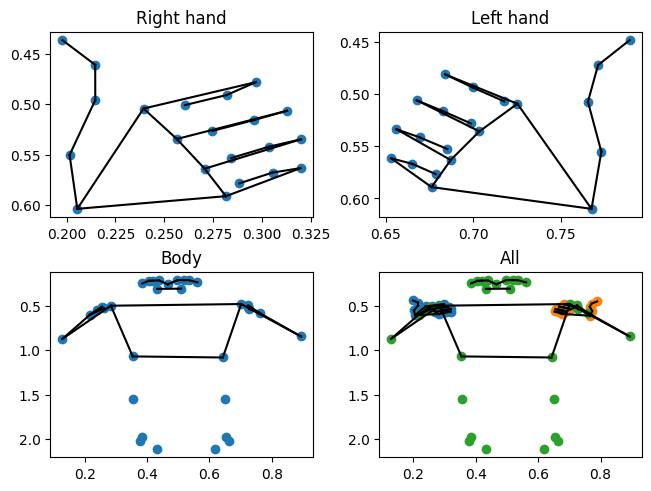

In [145]:
graph_drawer(pd.read_csv("test folder/Frame_22.csv"), edges)